# Spike timing dependent plasticity (STDP) rules

## Initialization

In [21]:
!pip install numpy scipy matplotlib ipywidgets scikit-learn --quiet
import numpy as np
import scipy.linalg as lin
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.style.use("https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/plots_style.txt")

## Plotting the pairwise STDP rule

###

In [22]:
def mySTDP_plot(A_plus, A_minus, tau_plus, tau_minus, Delta_t, dW):
  
'''
Generates a plot for the pairwise STDP rule

  A_plus : maximum amount of potentiation (LTP)
  A_minus: maximum amount of depression (LTD)
  tau_plus: LTP time constant
  tau_minus: LTD time constant 
  Delta_t : array with the time differences between post- and pre-synaptic spikes
  dW : synaptic change 
  
'''
  plt.figure()
  plt.plot([-5 * tau_minus, 5 * tau_plus], [0, 0], 'k', linestyle=':')
  plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

  plt.plot(Delta_t[Delta_t <= 0], dW[Delta_t <= 0], 'r')
  plt.plot(Delta_t[Delta_t > 0], dW[Delta_t > 0], 'b')

  plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)')
  plt.ylabel(r'$\Delta $W', fontsize=14)
  plt.title('Pairwise STDP rule', fontsize=12, fontweight='bold')
  plt.show()

In [23]:
def Delta_W(A_plus, A_minus, tau_plus, tau_minus, Delta_t):
  """
  Calculates the instantaneous change in weights dW due to the STDP pairwise rule

  A_plus : maximum amount of potentiation (LTP)
  A_minus: maximum amount of depression (LTD)
  tau_plus: LTP time constant
  tau_minus: LTD time constant 
  Delta_t : array with the time differences between post- and pre-synaptic spikes
  """

  # Initialize the STDP change
  dW = np.zeros(len(Delta_t))
  # Calculate dW for LTP
  dW[Delta_t > 0] = A_plus * np.exp(-Delta_t[Delta_t > 0] / tau_plus)
  # Calculate dW for LTD
  dW[Delta_t <= 0] = -A_minus * np.exp(Delta_t[Delta_t <= 0] / tau_minus)

  return dW

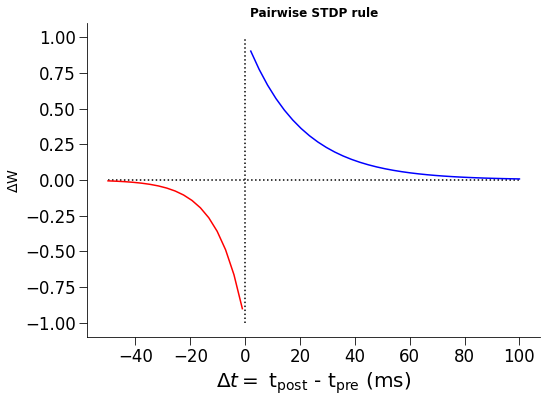

In [24]:
'''
Main
'''
# define the STDP rule parameters
A_plus = 1
A_minus = 1
tau_plus = 20  #[ms]
tau_minus = 10 #[ms]

Delta_t = np.linspace(-5 * tau_minus, 5 * tau_plus, 50)

dW = Delta_W(A_plus, A_minus, tau_plus, tau_minus, Delta_t)

mySTDP_plot(A_plus, A_minus, tau_plus, tau_minus, Delta_t, dW)
